## Objective of this Assignment:

<b>A US-based housing company named Surprise Housing</b> has decided to enter the Australian market.<br>
The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. 

The company wants to know:
1. Which variables are significant in predicting the price of a house?
1. How well those variables describe the price of a house?

### Business Goal:
Build an optimized model to identify the key predictor variables, so that Surprise Housing's management can understand
- how prices vary with these key predictor variables
- how to manipulate their strategy to yield high returns
- understand the pricing dynamics of a new market.

### Technical Goal:
- In addition to building the model, determine the optimal value of lambda for ridge and lasso regression.
---

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
pio.templates.default = "none"

text_bold_start = '\033[1m'
text_bold_end = '\033[0m'

---

### Function Definitions

In [2]:
'''This function gives a list of columns that have a columns values equal or above the specified threshold value'''
def get_columns_with_uneven_distr(thresh=0.8):
    drop_columns = []
    for col in house_sales.columns:
        value_distribution = house_sales[col].value_counts(normalize=True)
        if len(value_distribution.loc[value_distribution >= thresh])>0:
            drop_columns.append(col) 
    return drop_columns

'''This function keeps the specified n largest values and groups all other values into the category-Other'''
def keep_nlargest(col,nlargest=5):
    ref_list = list(house_sales[col].value_counts().nlargest(nlargest).index)
    house_sales[col] = house_sales[col].apply(lambda x: x if x in ref_list else 'Others')
    


''' This function can be used to build a linear regression model using OLS and get the model summary and VIF values'''
def build_lr_ols_model(X_train_lm,X_train):    

    lm = sm.OLS(y_train,X_train_lm).fit()
    print(lm.summary())

    vif = pd.DataFrame()
    vif['Features'] = X_train.columns
    vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending=False)
    print("==="*30)
    print('\n')
    print(vif)
    
    return lm


''' This function prints the key model metrics'''
def print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key,p):
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = round(r2_score(y_train, y_pred_train),4)
    r2_test = round(r2_score(y_test, y_pred_test),4)
    adj_r2_test = (1 - (((1-r2_test)*(len(y_test)-1))/(len(y_test)-p-1)))
    rss_train = round(np.sum(np.square(y_train - y_pred_train)),4)
    rss_test = round(np.sum(np.square(y_test - y_pred_test)),4)
    
    
    
    metrics_df = pd.DataFrame({'Key':pd.Series(key), 
                               'R2-Training': pd.Series(r2_train),
                               'R2-Test': pd.Series(r2_test),
                               'Adj-R2-Test': pd.Series(adj_r2_test),
                               'RSS-Train': pd.Series(rss_train),
                               'RSS-Test': pd.Series(rss_test),
                               'RMSE-Train': pd.Series(round(mse_train**0.5,4)),
                               'RMSE-Test': pd.Series(round(mse_test**0.5,4)) })
    
    return metrics_df

In [3]:
'''This function plots a plotly box subplots'''
def px_sub_plot_box(cols,df,title,title_plot,y=None,colnum=3,height=700,width=1100):
          
    sub_titles = tuple(title_plot)
    fig = make_subplots(rows=math.ceil(len(cols)/colnum), cols=colnum, subplot_titles=sub_titles)   
    i = 1
    j = 1
    for col in cols:
        if y !=None:
            fig.append_trace(go.Violin(y=df[y], x=df[col], name=col,box_visible=True), i, j)
            fig.update_yaxes(type="log")
        else:
            fig.append_trace(go.Violin(y=df[col], name=col,box_visible=True), i, j)
            
        if j!=colnum:
            j += 1
        else:
            j = 1
            i += 1

    fig['layout'].update(showlegend=True, title=title, boxmode='group',height=height, width=width)
    fig.show()
    

'''This function plots countplots for the categorical columns'''
def plot_count_categories(columns):
    
    fig, axes = plt.subplots(math.ceil(len(columns)/2), 2, figsize=(15, 30))
    axes = [i for ax in axes for i in ax]

    for ax, col in zip(axes, columns):
        sns.countplot(data=house_sales, x=col,ax=ax, order=house_sales[col].value_counts().index)
        if house_sales[col].value_counts().nunique() > 10:
            ax.tick_params(labelrotation=90)            

    fig.tight_layout()
    

'''This function plots distribution for the numerical columns'''
def plot_dist_numericals(columns,df):    
    fig, axes = plt.subplots(len(columns), 2, figsize=(15, 50))
    for ax, col in zip(axes, columns):
        sns.boxplot(x=df[col],ax=ax[0]) 
        sns.distplot(df[col],ax=ax[1])                  

    fig.tight_layout()

### Import Data and Initial Review

In [4]:
house_sales = pd.read_csv('train.csv')
print("{0}Number of rows in the dataset: {1}{2}".format(text_bold_start,house_sales.shape[0],text_bold_end))
print("{0}Number of columns in the dataset: {1}{2}".format(text_bold_start,house_sales.shape[1],text_bold_end))
print("\n"*2)
house_sales.head()

Number of rows in the dataset: 1460
Number of columns in the dataset: 81





Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [5]:
print(house_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

---
#### Inference:
1460 rows and 81 columns with number(float, int) and object dtypes. Few columns exist with missing values.

---
<br>

## Data Cleaning
1. Drop unwanted columns.
2. Handle missing values.
3. Validate and correct data.
4. Handle outliers.

In [6]:
house_sales.drop('Id', axis=1, inplace=True) # Drop ID column as it imparts no insight other than record number
house_sales.drop_duplicates(keep='first',inplace=True)

#### Handle Missing Values

In [7]:
house_sales.dropna(thresh=(round(0.7*len(house_sales))), axis=1, inplace=True) # Drop any columns with more than 70% missing values
house_sales.dropna(thresh=(round(0.7*len(house_sales.columns))), inplace=True) # Also,drop any rows with more than 70% missing values (incomplete records)
print("Number or rows and columns in the dataset: {0}, {1}".format(house_sales.shape[0], house_sales.shape[1]))

missing_values = round(100 * house_sales.isnull().sum()/len(house_sales))
print("\nColumns with missing values: \n{0}".format(missing_values[missing_values > 0].sort_values(ascending=False)))
del missing_values

Number or rows and columns in the dataset: 1460, 75

Columns with missing values: 
LotFrontage     18.0
GarageType       6.0
GarageYrBlt      6.0
GarageFinish     6.0
GarageQual       6.0
GarageCond       6.0
BsmtQual         3.0
BsmtCond         3.0
BsmtExposure     3.0
BsmtFinType1     3.0
BsmtFinType2     3.0
MasVnrType       1.0
MasVnrArea       1.0
dtype: float64


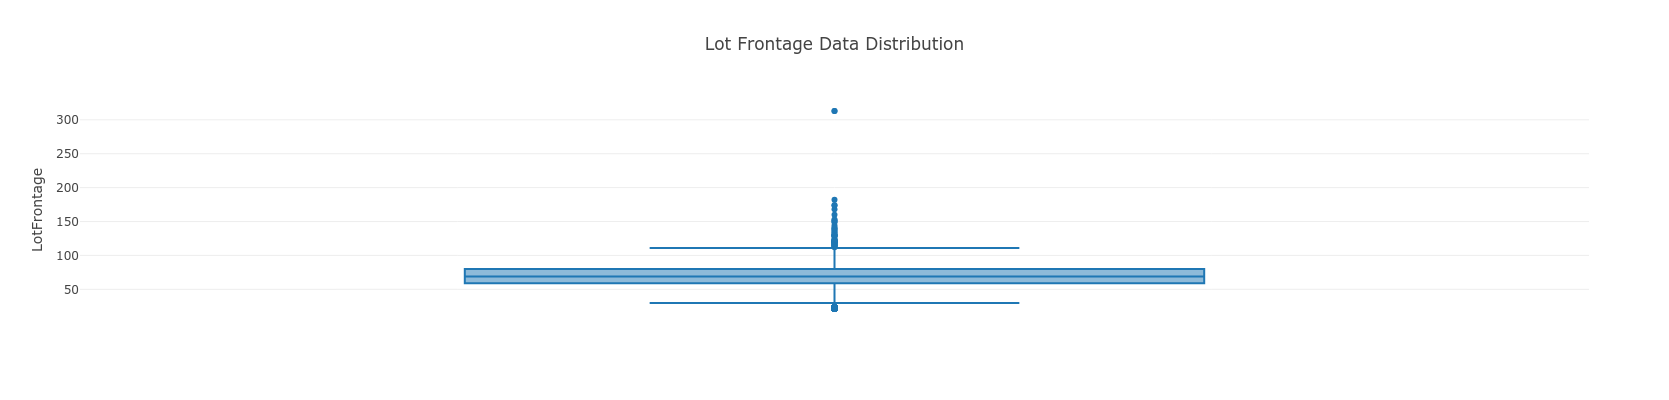

In [8]:
fig = px.box(house_sales, y="LotFrontage",title="Lot Frontage Data Distribution", height=400,width=600)
fig.show() #there seem to be outliers on both sides of the fences with significantly more outliers above the upper fence

In [9]:
# Impute Lotfrontage with median value due to the presence of outliers
house_sales.LotFrontage.fillna(house_sales.LotFrontage.median(),inplace=True)

# Impute the missing masonry veneer type with the most common category. 
house_sales.MasVnrType.fillna(house_sales.MasVnrType.mode()[0],inplace=True)

# If masonry veneer type is None, then the veneer area should be 0
house_sales.loc[(house_sales.MasVnrType=='None'),'MasVnrArea'] = 0

# Electrical system is highly improbable to be null, impute with most common category
house_sales.Electrical.fillna(house_sales.Electrical.mode()[0],inplace=True)

# If no garage, then garage relevant columns should be NA - No Garage
grg_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
house_sales.loc[(house_sales.GarageArea==0),grg_cols] = 'NA'

# If no basement, then basement relevant columns should be NA - No Basement
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
house_sales.loc[(house_sales.TotalBsmtSF==0),bsmt_cols] = 'NA'

# Evaluate the missing values after the above corrections
print("Columns with missing values: {0}".format(house_sales.columns[house_sales.isnull().any()].values))

Columns with missing values: ['BsmtExposure' 'BsmtFinType2' 'GarageYrBlt']


In [10]:
# Analyze the null entries for BsmtFinType2
bsmt_cols.extend(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'])
house_sales[house_sales.BsmtFinType2.isnull()][bsmt_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFinSF1  \
332       Gd       TA           No          GLQ          NaN        1124   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  
332         479       1603         3206

In [11]:
# There is one entry with Basement Fin Type 2 as null. 
# The entry has unfinished sf, meaning that atleast a part of total basement is unfinished. 
# Since Basement Fin type 1 is not unfinished, marking basement fin type 2 as 'UNF - Unfinished'
house_sales.BsmtFinType2.fillna('Unf', inplace=True)

In [12]:
# Analyze the null entries for BsmtExposure
house_sales[house_sales.BsmtExposure.isnull()][bsmt_cols]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFinSF1  \
948       Gd       TA          NaN          Unf          Unf           0   

     BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  
948           0        936          936

In [13]:
# Impute the BsmtExposure null value with mode/most common category
house_sales.BsmtExposure.fillna(house_sales.BsmtExposure.mode()[0],inplace=True)

In [14]:
# Analyze the null entries for GarageYrBlt
house_sales[house_sales.GarageYrBlt.isnull()]['GarageType'].value_counts()

NA    81
Name: GarageType, dtype: int64

- All the entries with no GarageYrBuilt Date are the ones that do not have a garage. So, will not impute a value

### Data Validations

In [15]:
# If the house has a masonry veneer then the area cannot be 0.
# Treat this as missing value and impute with median value.
house_sales.loc[((house_sales.MasVnrType != 'None') & (house_sales.MasVnrArea == 0)),'MasVnrArea'] = house_sales[(house_sales.MasVnrArea != 0)].MasVnrArea.median()

house_sales['MSZoning'] = house_sales.MSZoning.apply(lambda x: x if x != 'C (all)' else x[0])
house_sales['Neighborhood'] = house_sales.Neighborhood.apply(lambda x: x if x!= 'NAmes' else x.capitalize())
house_sales['Exterior2nd'] = house_sales.Exterior2nd.apply(lambda x: 'BrkComm' if x == 'Brk Cmn' else x)

# Treat the below column as category/string values
house_sales = house_sales.astype({'MSSubClass': str})

# Check if year built is invalid for each dwelling type
print("Invalid dates for SubClass - 20: {0}".format(len(house_sales[(house_sales.MSSubClass == '20') & (house_sales.YearBuilt < 1946)])))
print("Invalid dates for SubClass - 30: {0}".format(len(house_sales[(house_sales.MSSubClass == '30') & (house_sales.YearBuilt > 1945)])))
print("Invalid dates for SubClass - 60: {0}".format(len(house_sales[(house_sales.MSSubClass == '60') & (house_sales.YearBuilt < 1946)])))
print("Invalid dates for SubClass - 70: {0}".format(len(house_sales[(house_sales.MSSubClass == '70') & (house_sales.YearBuilt > 1945)])))
print("Invalid dates for SubClass - 120: {0}".format(len(house_sales[(house_sales.MSSubClass == '120') & (house_sales.YearBuilt < 1946)])))
print("Invalid dates for SubClass - 160: {0}".format(len(house_sales[(house_sales.MSSubClass == '160') & (house_sales.YearBuilt < 1946)])))

Invalid dates for SubClass - 20: 1
Invalid dates for SubClass - 30: 1
Invalid dates for SubClass - 60: 0
Invalid dates for SubClass - 70: 0
Invalid dates for SubClass - 120: 0
Invalid dates for SubClass - 160: 0


In [16]:
# Impute the invalid 'year built' values with Remodeled year
house_sales.loc[((house_sales.MSSubClass == '20') & (house_sales.YearBuilt < 1946)),'YearBuilt'] = house_sales[(house_sales.MSSubClass == '20') & (house_sales.YearBuilt < 1946)].YearRemodAdd
house_sales.loc[((house_sales.MSSubClass == '30') & (house_sales.YearBuilt > 1945)),'YearBuilt'] = house_sales[(house_sales.MSSubClass == '30') & (house_sales.YearBuilt > 1945)].YearRemodAdd

#### Derive Metrics

In [17]:
# Derive age columns using the Year columns
house_sales['BuildingAge'] = house_sales['YrSold'] - house_sales['YearBuilt']
house_sales['RemodelAge'] = house_sales['YrSold'] - house_sales['YearRemodAdd']
house_sales['TotalPorchSF'] = house_sales['WoodDeckSF'] + house_sales['OpenPorchSF']
house_sales['BedroomRatioAbvGrade'] = house_sales['BedroomAbvGr']/house_sales['TotRmsAbvGrd']
house_sales['TotalBaths'] = house_sales['FullBath'] + (0.5*house_sales['HalfBath']) + house_sales['BsmtFullBath']

# 1stFlrSF and 2ndFlrSF along with LowQualFinSF makeup the GrLivArea, so shall keep only one of them
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF makeup the TotalBsmtSF, so shall keep only one of them
drop_columns = ['WoodDeckSF','OpenPorchSF','BedroomAbvGr','TotRmsAbvGrd','FullBath','HalfBath','BsmtFullBath',
                'YearBuilt','YearRemodAdd','GarageYrBlt','1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']
house_sales.drop(drop_columns, axis=1, inplace=True)
del drop_columns

print("No. of rows with building age less than remodeled age: {0}".
      format(len(house_sales[house_sales.BuildingAge < house_sales.RemodelAge])))

No. of rows with building age less than remodeled age: 0


#### Drop unwanted columns

In [18]:
# Any columns with a specific value more than 80% (class imbalance) will be dropped. 
print(f"Number of columns before dropping: {house_sales.shape[1]}") 
house_sales.drop(get_columns_with_uneven_distr(0.8),axis=1,inplace=True)
print(f"Number of columns after dropping: {house_sales.shape[1]}") 

# Also drop duplicates
print(f"Number of rows before dropping: {house_sales.shape[0]}") 
house_sales.drop_duplicates(inplace=True,keep='first')
print(f"Number of rows after dropping: {house_sales.shape[0]}") 

Number of columns before dropping: 64
Number of columns after dropping: 37
Number of rows before dropping: 1460
Number of rows after dropping: 1460


#### Date Columns

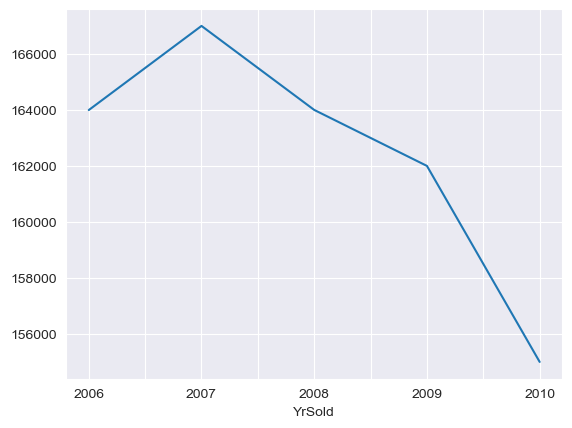

In [19]:
house_sales = house_sales.astype({'MoSold': str,'YrSold':str})
house_sales.groupby('YrSold')['SalePrice'].median().plot()
plt.show()

#### Inference:
The median house sales price declined from 2008 till 2010 which could be attributed to the <a href='https://www.noradarealestate.com/blog/housing-market-crash-2008/#:~:text=In%20summary%2C%20the%202008%20housing,are%20still%20being%20felt%20today.'>housing market crash of 2008</a> which lasted for many years.

---

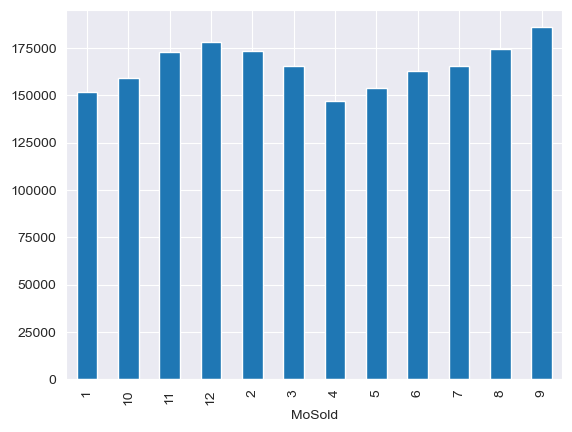

In [20]:
house_sales.groupby('MoSold')['SalePrice'].median().plot.bar()
plt.show()

#### Inference:
The median house sales price show some seasonality trend across the months. Will keep this column to evaluate if this is a key predictor.


---
#### Numerical Columns

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


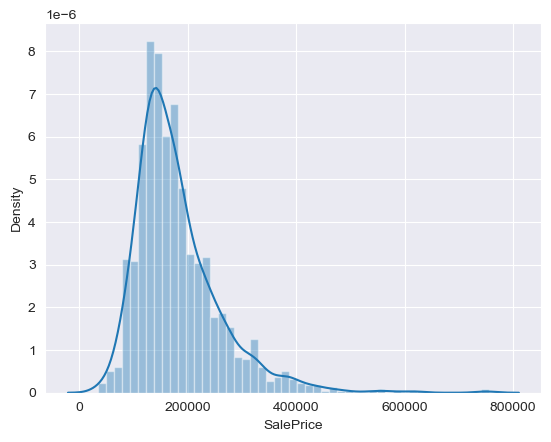

In [21]:
# Check if the target variable SalePrice's distribution is normal
num_cols = house_sales.select_dtypes(np.number).columns
print(house_sales.SalePrice.describe())
sns.distplot(house_sales.SalePrice)  
plt.show()

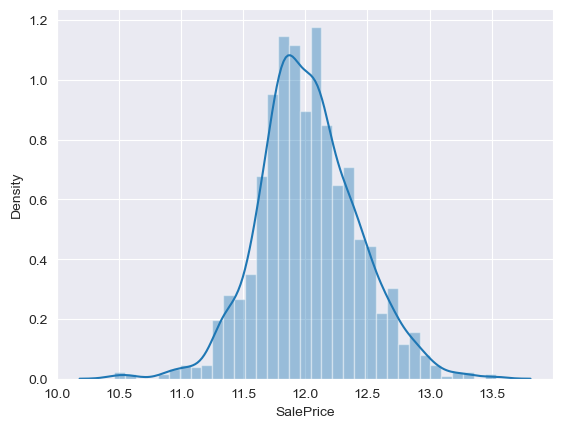

In [22]:
# Sales Prices' distribution is right skewed. Check if log transformation would improve the distribution
sns.distplot(np.log1p(house_sales.SalePrice))  
plt.show()

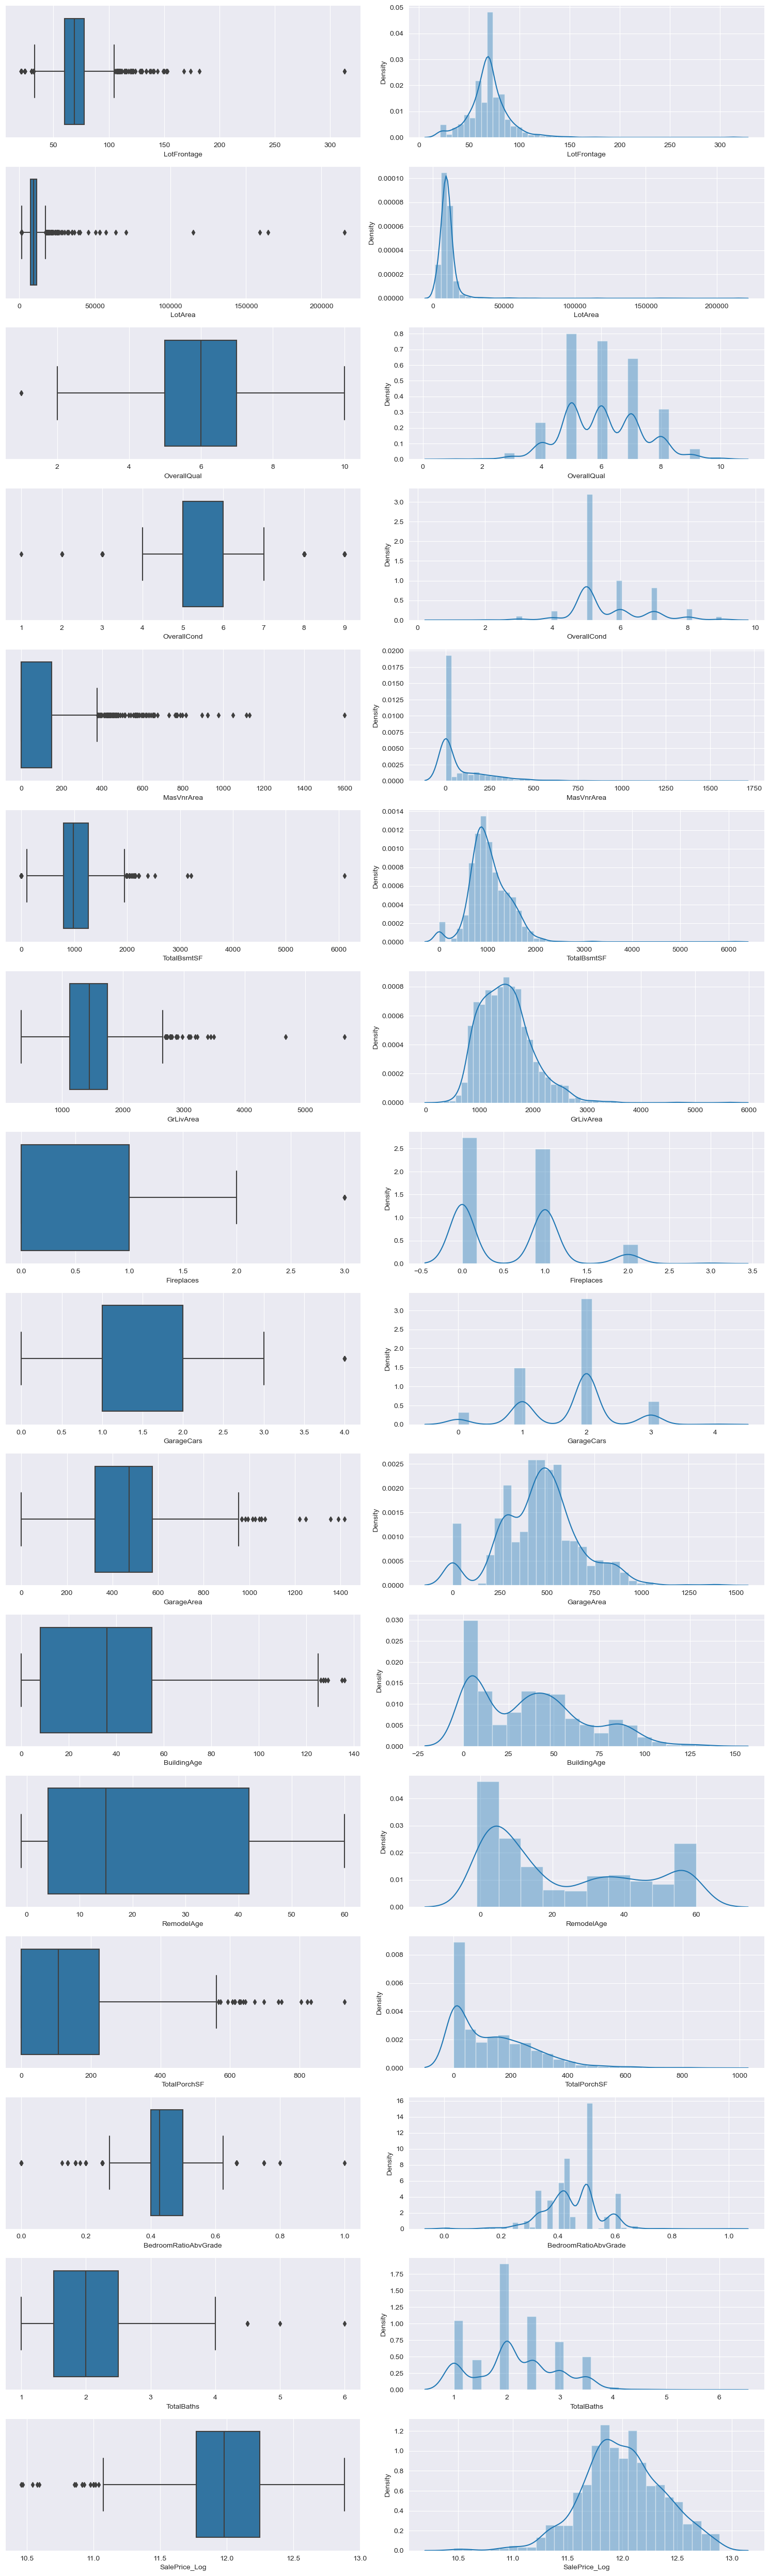

In [23]:
# After log transforming sales price column looks like an almost Gaussian Distribution.
# So, will transform the sales price (target variable) using log transformation.
house_sales['SalePrice_Log'] = np.log1p(house_sales.SalePrice)
house_sales.drop('SalePrice',inplace=True,axis=1)

house_sales = house_sales[house_sales['SalePrice_Log'] <= house_sales.SalePrice_Log.quantile(0.98)] # remove outliers

# Check the distribution of the numeric columns
num_cols = house_sales.select_dtypes(np.number).columns
plot_dist_numericals(num_cols,house_sales)

In [24]:
#From the observed items, handling the key columns' outliers using quantiles
major_outliers = ['LotArea','LotFrontage','GrLivArea','TotalBsmtSF','GarageArea','TotalPorchSF','BuildingAge','OverallCond']
for outlier in major_outliers:
    # house_sales[outlier] = pd.Series(winsorize(house_sales[outlier],(0.10,0.05)))
    quant_10 = house_sales[outlier].quantile(0.1)
    quant_95 = house_sales[outlier].quantile(0.95)
    house_sales[outlier] = np.where(house_sales[outlier] <= quant_10,
                                    quant_10, 
                                    np.where(house_sales[outlier] >= quant_95, 
                                             quant_95, 
                                             house_sales[outlier]))



print(house_sales.shape)

(1430, 37)


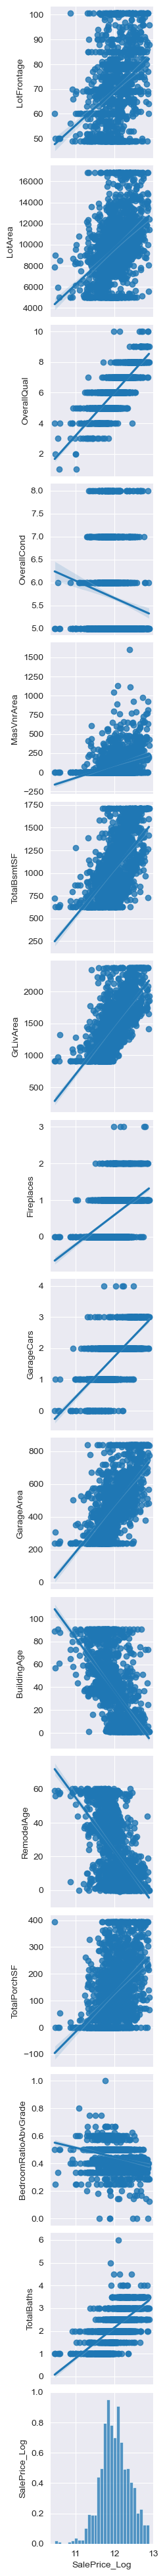

In [25]:
# Also perform bivariate analysis to check which features exhibit a linear relationship with the log of sales price
num_cols = house_sales.select_dtypes(np.number).columns
sns.pairplot(house_sales, x_vars='SalePrice_Log', y_vars=num_cols,kind="reg")
plt.show()

Several features display a linear relationship with the log of Sales Price. Example:
- Lot Area
- Above grade living area
- Building Age (negative corr)
- Overall Quality
- Total Basement SF

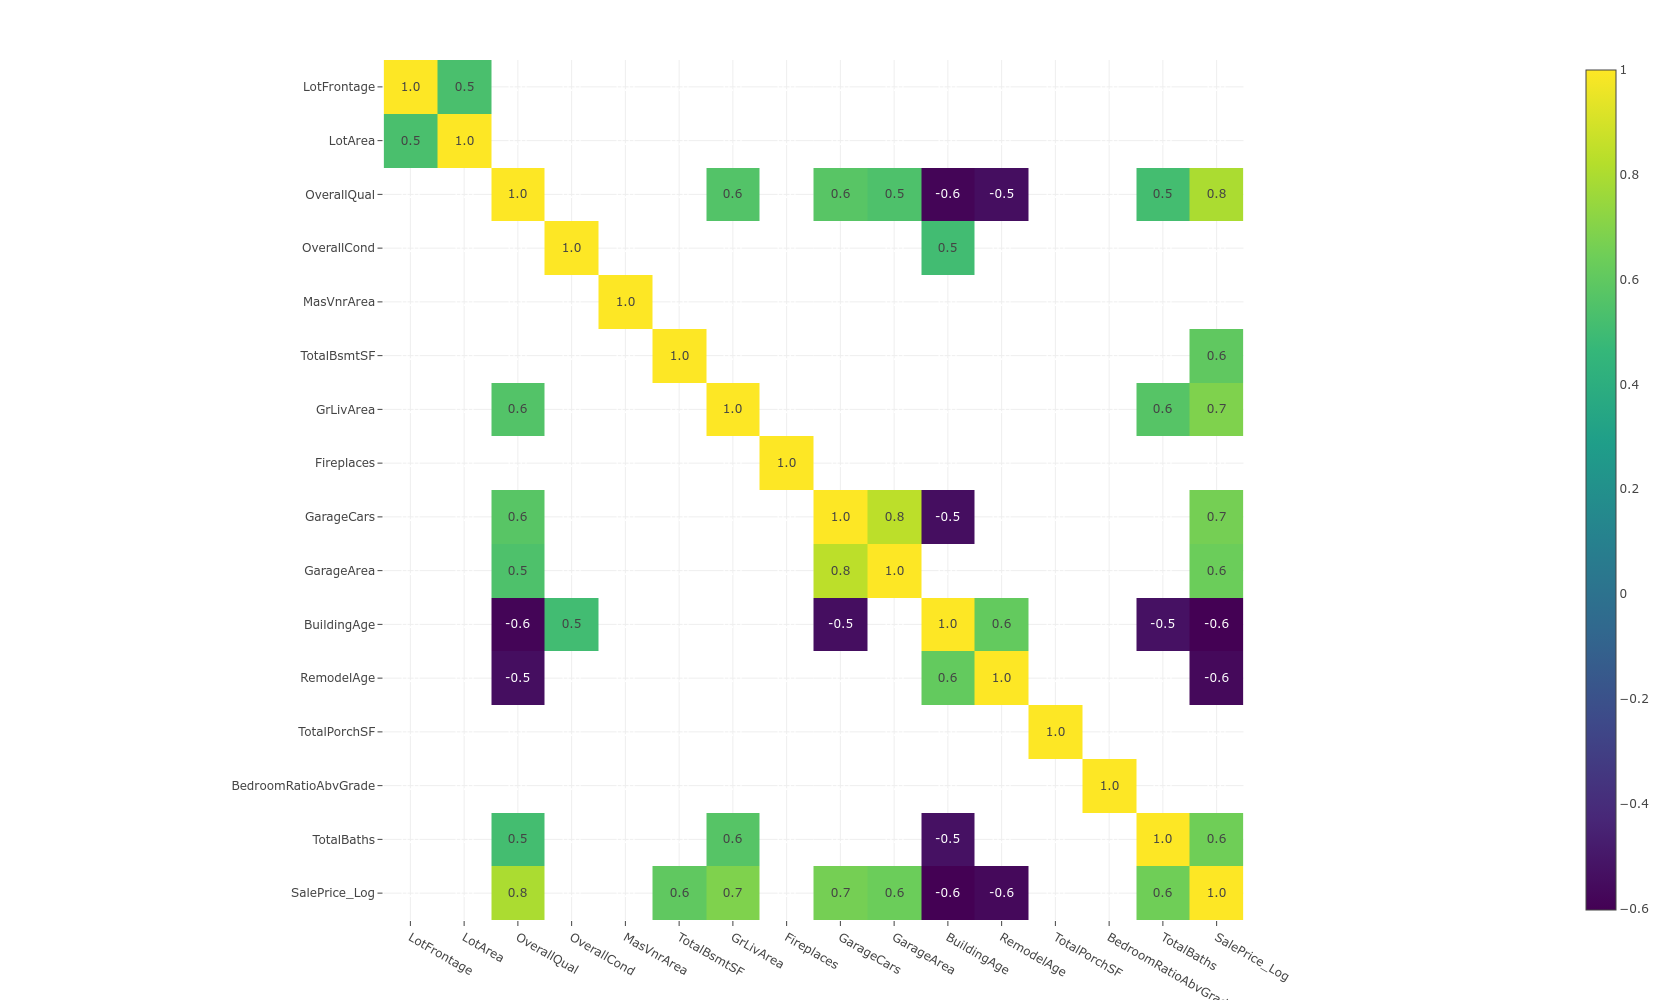

In [26]:
# Evaulate the correlation of the numerical columns
corr_df = house_sales.corr(numeric_only=True)
fig = px.imshow(corr_df[abs(corr_df) >= 0.5], text_auto='.1f',width=1200,height=1000)
fig.show()

1. There are several columns which are correlated with the Sales Price
    - Overall Quality
    - Total Basement SF
    - Above Grade Living Area
    - Garage Cars
    - Garage Area
    - Building Age/Remodel Age
    - Total Bathrooms    
    
1. Garage Area and Garage Cars are highly correlated and since storage capacity of number of cars is a common term used, will keep garage cars feature.

In [27]:
house_sales.drop(['GarageArea'],axis=1,inplace=True)

#### Categorical Columns

In [28]:
obj_cols = house_sales.select_dtypes(['object']).columns
house_sales[obj_cols].describe().T

count unique      top  freq
MSSubClass    1430     15       20   524
MSZoning      1430      5       RL  1122
LotShape      1430      4      Reg   915
LotConfig     1430      5   Inside  1033
Neighborhood  1430     25    Names   225
HouseStyle    1430      8   1Story   714
RoofStyle     1430      6    Gable  1131
Exterior1st   1430     15  VinylSd   496
Exterior2nd   1430     16  VinylSd   485
MasVnrType    1430      4     None   867
ExterQual     1430      4       TA   906
Foundation    1430      6   CBlock   633
BsmtQual      1430      5       TA   648
BsmtExposure  1430      5       No   947
BsmtFinType1  1430      7      Unf   424
HeatingQC     1430      5       Ex   712
KitchenQual   1430      4       TA   735
GarageType    1430      7   Attchd   850
GarageFinish  1430      4      Unf   604
MoSold        1430     12        6   250
YrSold        1430      5     2009   330

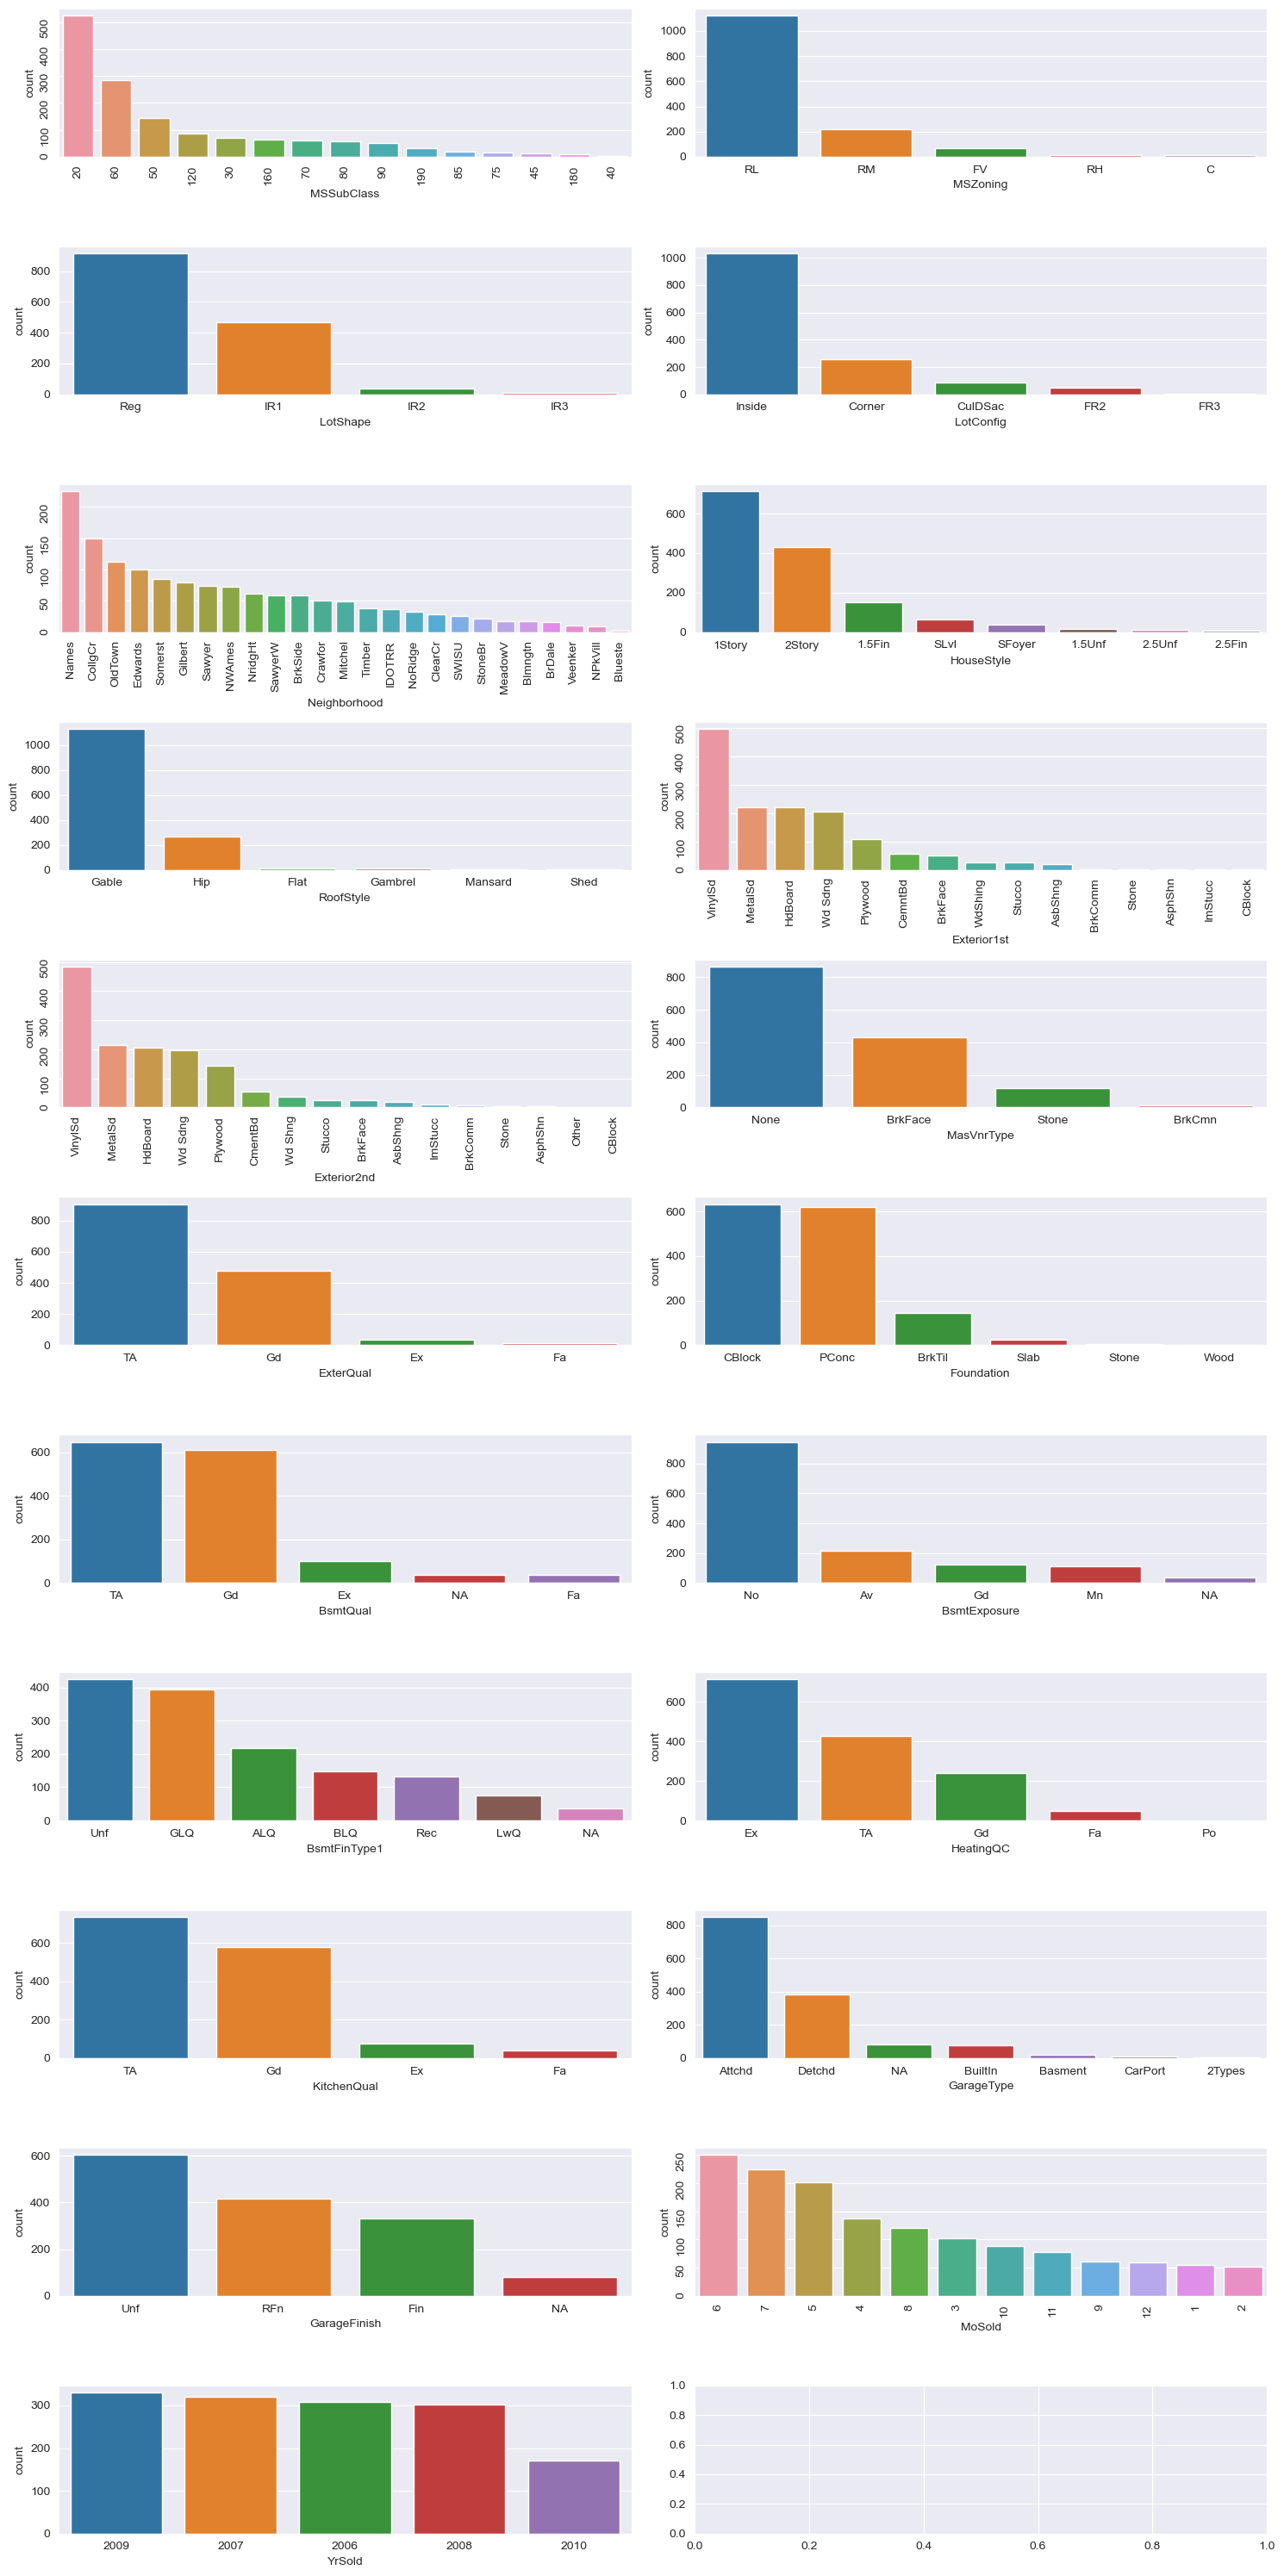

In [29]:
plot_count_categories(obj_cols)

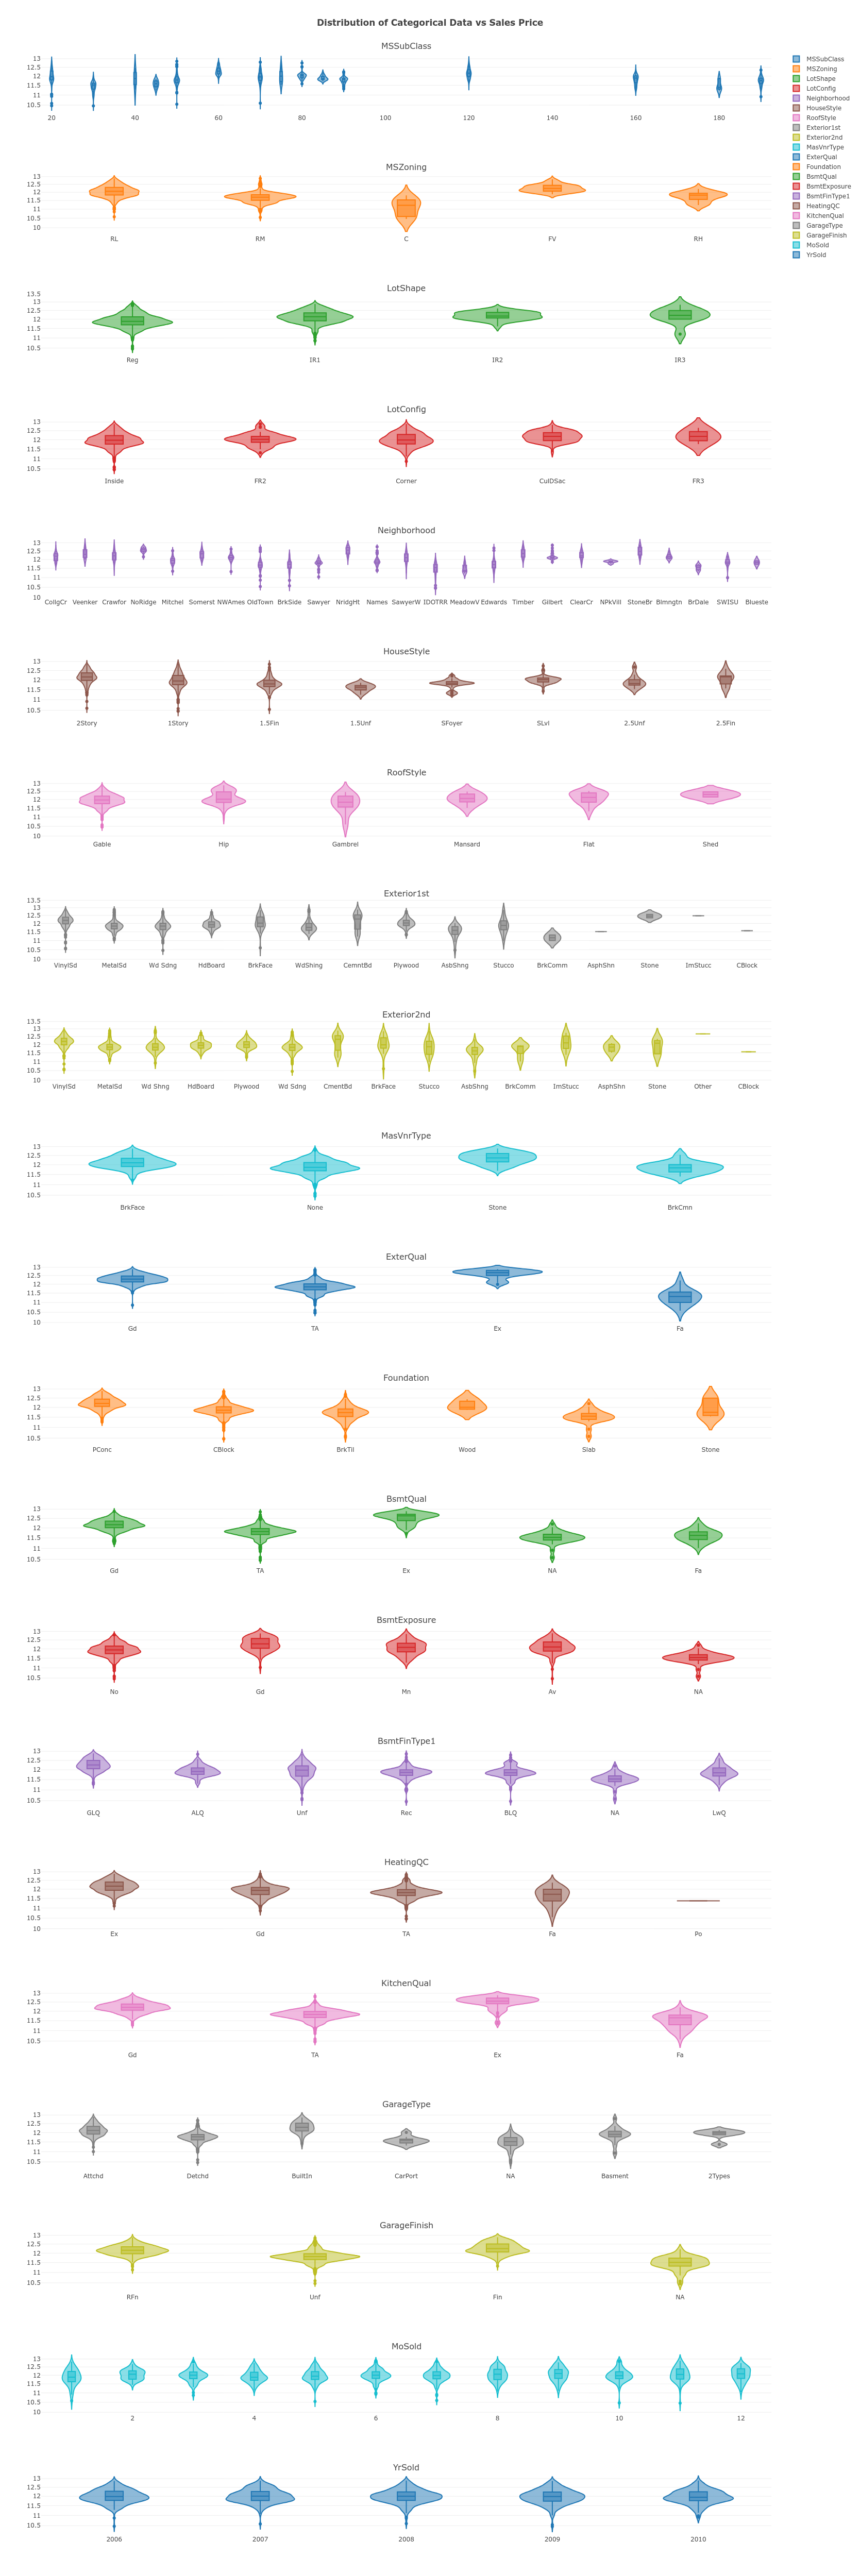

In [30]:
title='<b>Distribution of Categorical Data vs Sales Price</b>'
title_plot = obj_cols
px_sub_plot_box(obj_cols,house_sales,title,title_plot,y='SalePrice_Log',colnum=1,height=5000,width=1500)

- Even though the general trend is that 'Commercial' properties are costlier, the current data set shows that the commercial zoning houses have the lowest median value.
- The highest median house sales price appears to be for houses of type '60' followed by '120' i.e. 2-Story homes and PUDs that are constructed in 1946 or later.
- The irregular lot shapes have higher median house sales price than the regular lot shapes, probably due to the flexibility for custom designs offered by irregular lot shapes.
- As the overall quality of the house goes up, the house sales prices also goes up.
- Houses with excellent External, Kitchen and Basement quality tend to have higher house_sales prices.

### Dummy Category Variables

In [31]:
obj_cols = house_sales.select_dtypes(['object']).columns
house_sales = pd.get_dummies(columns = obj_cols,data=house_sales,drop_first=True) 
house_sales.shape

(1430, 161)

---

### Split dataset into test and train datasets

In [32]:
house_sales_train, house_sales_test = train_test_split(house_sales, train_size=0.7, random_state=100) 
print(house_sales.shape)
print(house_sales_train.shape)
print(house_sales_test.shape)

(1430, 161)
(1000, 161)
(430, 161)


### Scale using MinMax Scaler

- Will use MinMax Scaler to scale the numeric values that are out of scale, to ensure that all variables get equal importance during model building. 
    - MinMaxScaler also known as Normalization will then set the specified numeric columns to fall into the range [0,1].
    - Formula for MinMax Scaling is x = (x - xmin)/(xmax - xmin)

In [33]:
scaler = MinMaxScaler()
scale_vars = house_sales.select_dtypes(np.number).columns 

house_sales_train[scale_vars] = scaler.fit_transform(house_sales_train[scale_vars])
house_sales_train.describe().T # now all columns have their minimum value at 0 and maximum value at 1

house_sales_test[scale_vars] = scaler.transform(house_sales_test[scale_vars])

### Extract X and y variables from the training dataset

In [34]:
y_train = house_sales_train.pop('SalePrice_Log')
X_train = house_sales_train

y_test = house_sales_test.pop('SalePrice_Log')
X_test = house_sales_test

### Intial feature selection through RFE

- Since RFE performs much faster in terms of feature selection than the regularization algorithms,
will first remove some of the features  <br>through RFE before handling detailed feature selection and handling multicollinearity through regularization.

In [35]:
# Build the first model using RFE and idenfity the top 60 features 
lm = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(estimator=lm, n_features_to_select=60)
rfe = rfe.fit(X_train,y_train)
rfe_cols = X_train.columns[rfe.support_] 
print(rfe_cols) # useful columns per RFE

Index(['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF', 'GrLivArea',
       'Fireplaces', 'GarageCars', 'BuildingAge', 'RemodelAge', 'TotalBaths',
       'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSSubClass_30',
       'MSSubClass_85', 'MSSubClass_90', 'MSZoning_FV', 'MSZoning_RH',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR3', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_Crawfor', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'RoofStyle_Mansard',
       'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace',
       'Exterior1st_CBlock', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc',
       'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_WdShing',
       'Exterio

In [36]:
reg = LinearRegression() 
X_train = X_train[rfe_cols]
X_test = X_test[rfe_cols]
reg.fit(X_train[rfe_cols],y_train)

X_train = X_train[rfe_cols]
X_train_lm = sm.add_constant(X_train)
lr_rfe_model = build_lr_ols_model(X_train_lm,X_train)

                            OLS Regression Results                            
Dep. Variable:          SalePrice_Log   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     167.3
Date:                Fri, 27 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:18:50   Log-Likelihood:                 1655.1
No. Observations:                1000   AIC:                            -3196.
Df Residuals:                     943   BIC:                            -2917.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2295 

As can be seen with the OLS summary and the VIF values, this model with 60 features is not stable with insignificant features that are multicollinear (high p-values and high VIF).
<br> Shall now use the two regularization techniques (Ridge and Lasso) for feature selection and also handling multicollinearity (reduce impact of multicollinearity through coefficient values)

---

### Regularization - Ridge

In [37]:
params_grid = {'alpha': [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 
                         0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 20,
                         40, 50, 100, 200, 400, 600, 800, 1000]}

ridge_reg = Ridge()
kfolds = 5
ridge_model_gridcv = GridSearchCV(estimator = ridge_reg,
                                  param_grid = params_grid,
                                  scoring = 'neg_mean_absolute_error',
                                  cv=kfolds,
                                  return_train_score = True,
                                  verbose = 1)
ridge_model_gridcv.fit(X_train,y_train)

print(ridge_model_gridcv.best_params_)
print(ridge_model_gridcv.best_score_)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
{'alpha': 2}
-0.034401514996535966


In [38]:
# Build the best lambda based ridge regression model
alpha = ridge_model_gridcv.best_params_.get('alpha')
ridge_model = Ridge(alpha)
ridge_model.fit(X_train,y_train)
y_pred_train = ridge_model.predict(X_train)
y_pred_test= ridge_model.predict(X_test)
metrics_df = print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key="Ridge",p=len(ridge_model.coef_[ridge_model.coef_>0]))
metrics_df

Key  R2-Training  R2-Test  Adj-R2-Test  RSS-Train  RSS-Test  RMSE-Train  \
0  Ridge       0.9043    0.874     0.861754     2.2364    1.2979      0.0473   

   RMSE-Test  
0     0.0549

In [39]:
# Check the rounded coefficient values determined by the ridge lr model
house_sales_ridge = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':ridge_model.coef_.round(4)})
house_sales_ridge = house_sales_ridge.sort_values(by='Coefficient', key=abs,ascending=False).reset_index(drop=True)
house_sales_ridge

Feature  Coefficient
0            OverallQual       0.1808
1              GrLivArea       0.1421
2            BuildingAge      -0.0978
3            MSZoning_FV       0.0936
4             GarageCars       0.0860
5            MSZoning_RH       0.0697
6    Exterior1st_BrkComm      -0.0652
7            OverallCond       0.0631
8             TotalBaths       0.0620
9            MSZoning_RL       0.0600
10           TotalBsmtSF       0.0562
11  Neighborhood_Crawfor       0.0557
12  Neighborhood_StoneBr       0.0556
13          LotShape_IR3      -0.0484
14               LotArea       0.0484
15   Exterior1st_BrkFace       0.0471
16        MSSubClass_160      -0.0451
17  Neighborhood_BrkSide       0.0439
18   Exterior2nd_CmentBd       0.0414
19            Fireplaces       0.0407
20         MSSubClass_30      -0.0395
21        MSSubClass_180      -0.0336
22  Neighborhood_MeadowV      -0.0323
23   Exterior1st_MetalSd       0.0319
24         MSSubClass_90      -0.0311
25         GarageType_NA      -0.0303
26     RoofStyle_Mansard       0.0302
27   Exterior1st_VinylSd       0.0298
28           MSZoning_RM       0.0297
29           BsmtQual_TA      -0.0296
30            RemodelAge      -0.0291
31  Neighborhood_NridgHt       0.0272
32        MSSubClass_190      -0.0260
33     HouseStyle_2.5Unf       0.0257
34       BsmtFinType1_NA      -0.0252
35           BsmtQual_NA      -0.0252
36       BsmtExposure_NA      -0.0252
37          HeatingQC_Po      -0.0243
38   Exterior2nd_Wd Sdng       0.0238
39           BsmtQual_Gd      -0.0229
40  Neighborhood_NoRidge       0.0218
41   Neighborhood_NWAmes      -0.0218
42  Neighborhood_ClearCr       0.0217
43   Exterior1st_Plywood       0.0211
44       BsmtExposure_Gd       0.0206
45      BsmtFinType1_Unf      -0.0200
46   Exterior2nd_BrkFace       0.0197
47      Foundation_Stone       0.0194
48   Exterior1st_HdBoard       0.0188
49  Neighborhood_Mitchel      -0.0175
50     Exterior1st_Stone       0.0174
51   Exterior1st_WdShing       0.0142
52    Exterior1st_Stucco       0.0135
53   Exterior1st_AsphShn       0.0112
54   Neighborhood_IDOTRR       0.0084
55    Exterior2nd_CBlock       0.0079
56    Exterior1st_CBlock       0.0079
57     HouseStyle_SFoyer       0.0073
58         MSSubClass_85      -0.0061
59   Exterior1st_ImStucc       0.0000

- The best lambda value through the Grid search Cross validation using 5 folds is 2, for Ridge regularization.
- The top features for this model are Overall Quality of the house, the above grade living area, the year house was built, <br>the floating village and residential high density zones, the number of cars accomodated by the garage etc.
    - OverallQual - 0.1808
    - GrLivArea - 0.1421
    - BuildingAge - (-0.0978)
    - MSZoning_FV - 0.0936
    - GarageCars - 0.0860
    - MSZoning_RH - 0.0697
    - Exterior1st_BrkComm - (-0.0652)
    - OverallCond - 0.0631
    - TotalBaths - 0.0620
    - MSZoning_RL - 0.0600
    
- Of these top features, Year built(building age) (and Exterior covering is brick common) is negatively correlated with the sales price indicating that older houses have lesser price than newer houses with all other house features being similar.

### Regularization - Lasso

In [40]:
params_grid = {'alpha': [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.005, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 20,
           40, 50, 100]}

lasso_reg = Lasso()
kfolds = 5
lasso_model_gridcv = GridSearchCV(estimator = lasso_reg,
                                  param_grid = params_grid,
                                  scoring = 'neg_mean_absolute_error',
                                  cv=kfolds,
                                  return_train_score = True,
                                  verbose = 1)
lasso_model_gridcv.fit(X_train,y_train)
print(lasso_model_gridcv.best_params_)
print(lasso_model_gridcv.best_score_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
{'alpha': 0.0001}
-0.03481377779055245


In [41]:
alpha = lasso_model_gridcv.best_params_.get('alpha')
lasso_model = Lasso(alpha)
lasso_model.fit(X_train,y_train)
y_pred_train = lasso_model.predict(X_train)
y_pred_test= lasso_model.predict(X_test)
metrics_df = metrics_df.append(print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key='Lasso',p=len(lasso_model.coef_[lasso_model.coef_>0])))
metrics_df

Key  R2-Training  R2-Test  Adj-R2-Test  RSS-Train  RSS-Test  RMSE-Train  \
0  Ridge       0.9043   0.8740     0.861754     2.2364    1.2979      0.0473   
0  Lasso       0.9039   0.8778     0.868282     2.2470    1.2592      0.0474   

   RMSE-Test  
0     0.0549  
0     0.0541

In [42]:
house_sales_lasso = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':lasso_model.coef_.round(4)})
house_sales_lasso = house_sales_lasso.sort_values(by='Coefficient', key=abs,ascending=False).reset_index(drop=True)
house_sales_lasso

Feature  Coefficient
0            OverallQual       0.2100
1              GrLivArea       0.1441
2            MSZoning_FV       0.1050
3            BuildingAge      -0.1016
4    Exterior1st_BrkComm      -0.0907
5             GarageCars       0.0878
6            MSZoning_RH       0.0820
7            MSZoning_RL       0.0710
8            OverallCond       0.0662
9             TotalBaths       0.0580
10           BsmtQual_NA      -0.0557
11           TotalBsmtSF       0.0553
12  Neighborhood_Crawfor       0.0536
13  Neighborhood_StoneBr       0.0521
14               LotArea       0.0471
15        MSSubClass_160      -0.0467
16          LotShape_IR3      -0.0466
17   Exterior1st_BrkFace       0.0420
18  Neighborhood_BrkSide       0.0413
19           MSZoning_RM       0.0400
20            Fireplaces       0.0374
21         MSSubClass_30      -0.0346
22         MSSubClass_90      -0.0290
23         GarageType_NA      -0.0289
24   Exterior2nd_CmentBd       0.0250
25            RemodelAge      -0.0249
26           BsmtQual_TA      -0.0244
27     RoofStyle_Mansard       0.0240
28  Neighborhood_NridgHt       0.0235
29  Neighborhood_MeadowV      -0.0225
30        MSSubClass_180      -0.0222
31   Neighborhood_NWAmes      -0.0215
32      BsmtFinType1_Unf      -0.0203
33   Exterior1st_MetalSd       0.0202
34        MSSubClass_190      -0.0200
35       BsmtExposure_Gd       0.0200
36           BsmtQual_Gd      -0.0197
37  Neighborhood_ClearCr       0.0194
38   Exterior1st_VinylSd       0.0162
39  Neighborhood_NoRidge       0.0151
40  Neighborhood_Mitchel      -0.0132
41     HouseStyle_2.5Unf       0.0129
42   Exterior2nd_Wd Sdng       0.0123
43       BsmtExposure_NA      -0.0116
44      Foundation_Stone       0.0097
45   Exterior1st_Plywood       0.0084
46   Exterior2nd_BrkFace       0.0074
47   Neighborhood_IDOTRR       0.0062
48   Exterior1st_HdBoard       0.0057
49          HeatingQC_Po      -0.0000
50       BsmtFinType1_NA      -0.0000
51     Exterior1st_Stone       0.0000
52    Exterior2nd_CBlock       0.0000
53   Exterior1st_WdShing       0.0000
54    Exterior1st_Stucco       0.0000
55   Exterior1st_ImStucc       0.0000
56         MSSubClass_85       0.0000
57   Exterior1st_AsphShn       0.0000
58     HouseStyle_SFoyer       0.0000
59    Exterior1st_CBlock       0.0000

1. The best lambda value through the Grid search Cross validation using 5 folds is 0.0001, for Lasso regularization.
1. The top features for this model are Overall Quality and condition of the house, the above grade living area, the number of cars accomodated by the garage, <br>the floating village zone, residential low density and high density zones, the year house was built, the total bathrooms in the house, exterior with brick common.
    - OverallQual - 0.2100
    - GrLivArea - 0.1441
    - MSZoning_FV - 0.1050
    - BuildingAge - (-0.1016)
    - Exterior1st_BrkComm - (-0.0907)
    - GarageCars - 0.0878
    - MSZoning_RH - 0.0820
    - MSZoning_RL - 0.0710
    - OverallCond - 0.0662
    - TotalBaths - 0.0580
1. Of these top features, Year built(building age) (and Exterior covering is brick common) is negatively correlated with the sales price indicating that older houses have lesser price than newer houses with all other house features being similar.

---

### Regularization Summary:
1. The lambda value for Ridge Regression is 2 and for Lasso Regression it is 0.0001.
1. After comparing the model metrics, it can be seen that the test dataset parameters fare better for Lasso Regression.
    - R2 and Adjusted R2 for test dataset are better for Lasso (higher) as compared to the Ridge model. Also, the RMSE is lower for the Lasso model as compare to Ridge model for the test dataset.
1. Since Lasso can also remove insignificant features (coeff = 0), it is chosen as the regularization algorithm for this use case.

### Final Model - Validation

The mean of the residuals is: 0.0



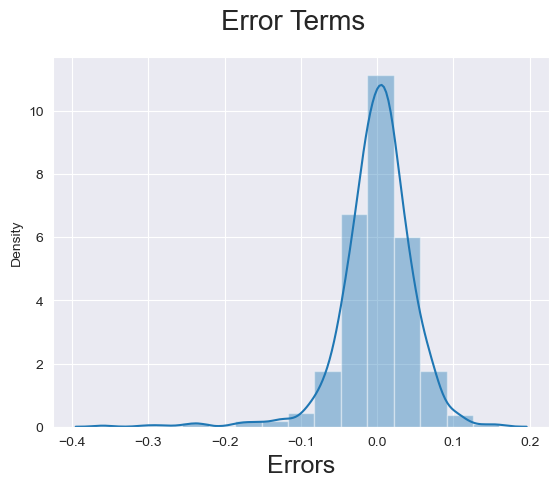

In [43]:
y_pred_train = lasso_model.predict(X_train)
residuals = y_train - y_pred_train

print("{0}The mean of the residuals is: {1}{2}\n".format(text_bold_start,round(np.mean(residuals),10),text_bold_end))

fig = plt.figure()
sns.distplot(residuals,bins=15)
fig.suptitle('Error Terms',fontsize=20)
plt.xlabel('Errors',fontsize=18)
plt.show() # mean is centered at 0 and the error terms also are normally distributed with some left skewing. So, the assumption is met.

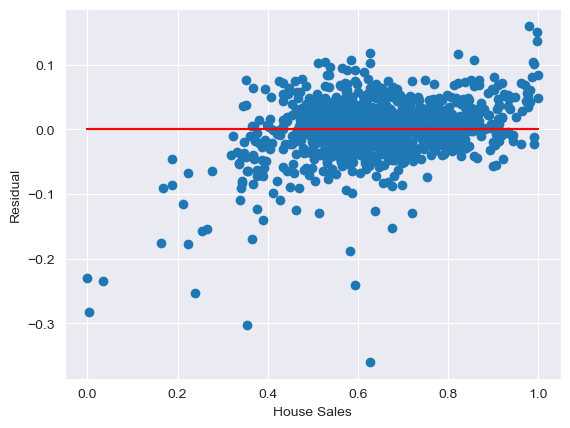

In [44]:
plt.scatter(y_train,residuals)
plt.plot(y_train,(y_train - y_train), '-r')
plt.xlabel('House Sales')
plt.ylabel('Residual')
plt.show() # no funnel like shape so no heteroscedasticity, so this assumption is also met.

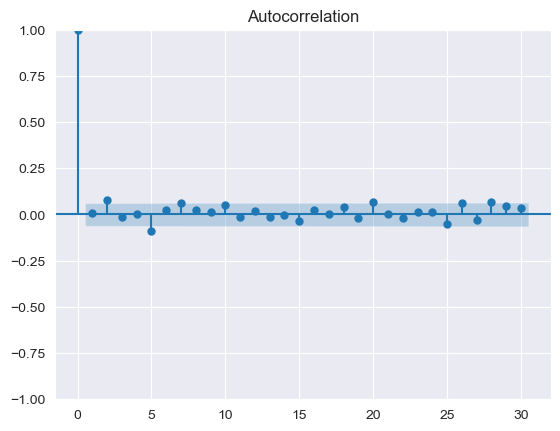

In [45]:
plot_acf(residuals); # the autocorrelation checks also seems acceptable

### Final Findings:

1. The optimal lambda values for Lasso and Ridge are:
    - Ridge: 2
    - Lasso: 0.0001
    
1. The RMSE for Lasso and Ridge models on the test dataset are:
    - Ridge: 0.0549
    - Lasso: 0.0541
        
1. The better choice of regularization for this use case is Lasso and the top 5 features are as below for the log-level model(Sale Price log transformed).
    | S.No. | Feature | Coefficient | Interpretation
    |-------|-----------|----------------|----|
    | 1. | OverallQual  | 0.2100 | For every unit increase in Overall quality there is a (100* 0.2100) i.e. 21% increase in Sales Price of the house.
    | 2. | GrLivArea | 0.1441 | For every unit increase in Above grade living area there is a (100* 0.1441) i.e. 14.41% increase in Sales Price of the house.
    | 3. | MSZoning_FV | 0.1050 |For houses in the Floating Village Residential zone there is a (100* 0.1050) i.e. 10.5% increase in Sales Price of the house.
    | 4. | BuildingAge | -0.1016 |For every unit increase in Building Age/Year Built there is a (100* 0.1016) i.e. 10.16% decrease in Sales Price of the house.
    | 5. | Exterior1st_BrkComm | -0.0907 | For houses with exterior with brick common there is a (100* 0.0907 ) i.e. 9.07% decrease in Sales Price of the house.

---
<br>

### Subjective Questions

---

#### Double lambda for Lasso and Ridge

In [46]:
# Double alpha for Ridge and build model
alpha = 2 * 2
ridge_model_double = Ridge(alpha)
ridge_model_double.fit(X_train,y_train)
y_pred_train = ridge_model_double.predict(X_train)
y_pred_test= ridge_model_double.predict(X_test)
metrics_df_double = print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key="Ridge",p=len(ridge_model_double.coef_[ridge_model_double.coef_>0]))

house_sales_ridge_double = pd.DataFrame({'Feature':X_train.columns,'Coefficient':ridge_model_double.coef_.round(4)})
house_sales_ridge_double = house_sales_ridge_double.sort_values(by='Coefficient', key=abs,ascending=False).reset_index(drop=True)


# Double alpha for Lasso and build model
alpha = 0.0001 * 2
lasso_model_double = Lasso(alpha)
lasso_model_double.fit(X_train,y_train)
y_pred_train = lasso_model_double.predict(X_train)
y_pred_test= lasso_model_double.predict(X_test)
metrics_df_double = metrics_df_double.append(print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key='Lasso',p=len(lasso_model_double.coef_[lasso_model_double.coef_>0])))
metrics_df_double

Key  R2-Training  R2-Test  Adj-R2-Test  RSS-Train  RSS-Test  RMSE-Train  \
0  Ridge       0.9012   0.8738     0.861535     2.3105    1.3002      0.0481   
0  Lasso       0.8987   0.8778     0.870559     2.3678    1.2590      0.0487   

   RMSE-Test  
0     0.0550  
0     0.0541

In [47]:
house_sales_lasso_double = pd.DataFrame({'Feature':X_train.columns, 'Coefficient':lasso_model_double.coef_.round(4)})
house_sales_lasso_double = house_sales_lasso_double.sort_values(by='Coefficient', key=abs,ascending=False).reset_index(drop=True)
print("Top Features for Ridge with doubled alpha: \n{0}".format( house_sales_ridge_double.head(10)))
print("\nTop Features for Lasso with doubled alpha: \n{0}".format( house_sales_lasso_double.head(10)))

Top Features for Ridge with doubled alpha: 
                Feature  Coefficient
0           OverallQual       0.1671
1             GrLivArea       0.1407
2           BuildingAge      -0.0926
3            GarageCars       0.0828
4           MSZoning_FV       0.0685
5            TotalBaths       0.0612
6           OverallCond       0.0603
7           TotalBsmtSF       0.0589
8  Neighborhood_Crawfor       0.0527
9  Neighborhood_StoneBr       0.0507

Top Features for Lasso with doubled alpha: 
                Feature  Coefficient
0           OverallQual       0.2203
1             GrLivArea       0.1465
2           BuildingAge      -0.1008
3            GarageCars       0.0857
4           OverallCond       0.0659
5           MSZoning_FV       0.0604
6           TotalBsmtSF       0.0585
7            TotalBaths       0.0547
8  Neighborhood_Crawfor       0.0501
9           BsmtQual_NA      -0.0495


---

#### Remove top 5 predictors of Lasso and rebuild model

In [48]:
# Remove top 5 featues and rebuild with optimal alpha
other_cols = X_train.drop(house_sales_lasso.head(5)['Feature'],axis=1).columns
X_train_other = X_train[other_cols]
X_test_other = X_test[other_cols]

alpha = lasso_model_gridcv.best_params_.get('alpha') 
lasso_model_no_top5 = Lasso(alpha)
lasso_model_no_top5.fit(X_train_other,y_train)
y_pred_train = lasso_model_no_top5.predict(X_train_other)
y_pred_test= lasso_model_no_top5.predict(X_test_other)
metrics_df_no_top5 = print_model_metrics(y_test,y_pred_test,y_train,y_pred_train,key='Lasso',p=len(lasso_model_no_top5.coef_[lasso_model_no_top5.coef_>0]))
metrics_df_no_top5

Key  R2-Training  R2-Test  Adj-R2-Test  RSS-Train  RSS-Test  RMSE-Train  \
0  Lasso        0.837   0.7938     0.779951     3.8101    2.1241      0.0617   

   RMSE-Test  
0     0.0703

In [49]:
house_sales_lasso_no_top5 = pd.DataFrame({'Feature':X_train_other.columns, 'Coefficient':lasso_model_no_top5.coef_.round(4)})
house_sales_lasso_no_top5 = house_sales_lasso_no_top5.sort_values(by='Coefficient', key=abs,ascending=False).reset_index(drop=True)
print("Top Features for Lasso with original top 5 features removed: \n{0}".format( house_sales_lasso_no_top5.head(5)))

Top Features for Lasso with original top 5 features removed: 
                Feature  Coefficient
0            TotalBaths       0.1766
1            GarageCars       0.1691
2            Fireplaces       0.1013
3  Neighborhood_StoneBr       0.0899
4         MSSubClass_30      -0.0879


1. New top 5 features:
    | S.No. | Feature | Coefficient | Interpretation
    |-------|-----------|----------------|----|
    | 1. | TotalBaths  | 0.2100 | For every unit increase in Total Bathrooms there is a (100* 0.1766) i.e. 17.66% increase in Sales Price of the house.
    | 2. | GarageCars | 0.1691 | For every unit increase in Cars accomodated by the garage there is a (100* 0.1691) i.e. 16.91% increase in Sales Price of the house.
    | 3. | Fireplaces | 0.1013 | For every unit increase in the fireplaces available there is a (100* 0.1013) i.e. 10.13% increase in Sales Price of the house.
    | 4. | Neighborhood_StoneBr | 0.0899 |For houses in the Stonebrook neighborhood there is a (100* 0.0899) i.e. 8.99% increase in Sales Price of the house.
    | 5. | MSSubClass_30 | -0.0879 | For houses of type '1-Story 1945 & older' there is a (100* 0.0879 ) i.e. 8.79% decrease in Sales Price of the house. 